In [2]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord, Galactic
import healpy as hp
import sys
sys.path.append('/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/scripts/')
import HSCMeasurementUtils
import healsparse
from scipy.stats import binned_statistic_2d

In [3]:
path = '/global/cfs/projectdirs/lsst/groups/LSS/HSC_reanalysis/data_javi/lens_sample_2023_pdr1'
path_save = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/mask/'

## 'Naive' mask

Working fine, yields a clustering measurement slightly higher than Nicola et al. tomographic analysis. We can do better than this simple approach.

###########################
Processing GAMA09H
###########################
Number of observed objects = 6496607
Number of stars = 1128219 (17.0%)
>> Mask type: galaxy


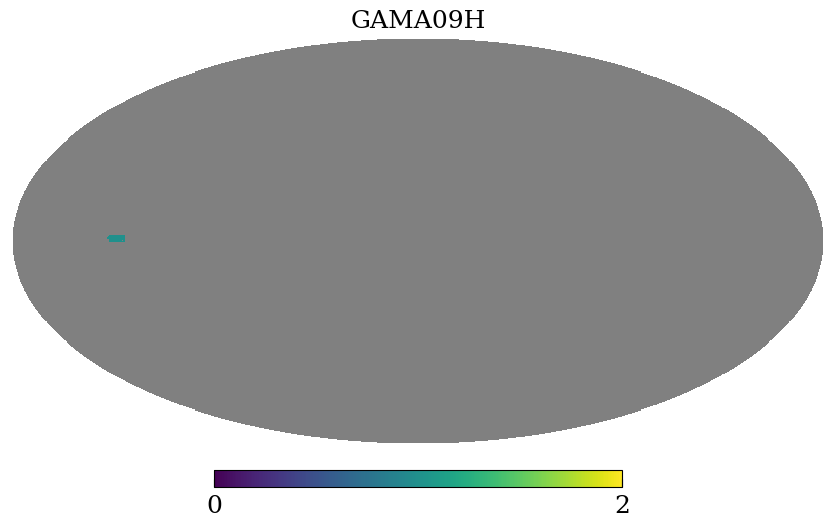

setting the output map dtype to [dtype('float64')]


>> Saving in Healpix format
>> Saving in Healsparse format
###########################
Processing GAMA15H
###########################
Number of observed objects = 7681225
Number of stars = 1384985 (18.0%)
>> Mask type: galaxy


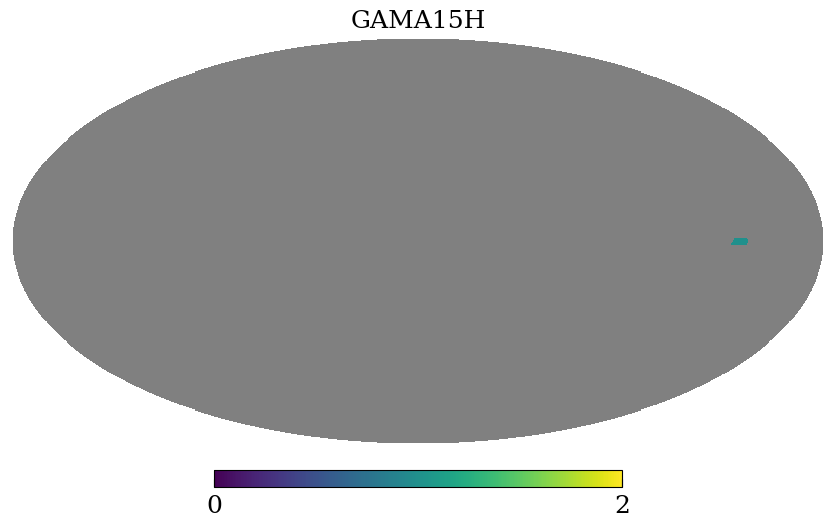

setting the output map dtype to [dtype('float64')]


>> Saving in Healpix format
>> Saving in Healsparse format
###########################
Processing WIDE12H
###########################
Number of observed objects = 5625072
Number of stars = 898111 (16.0%)
>> Mask type: galaxy


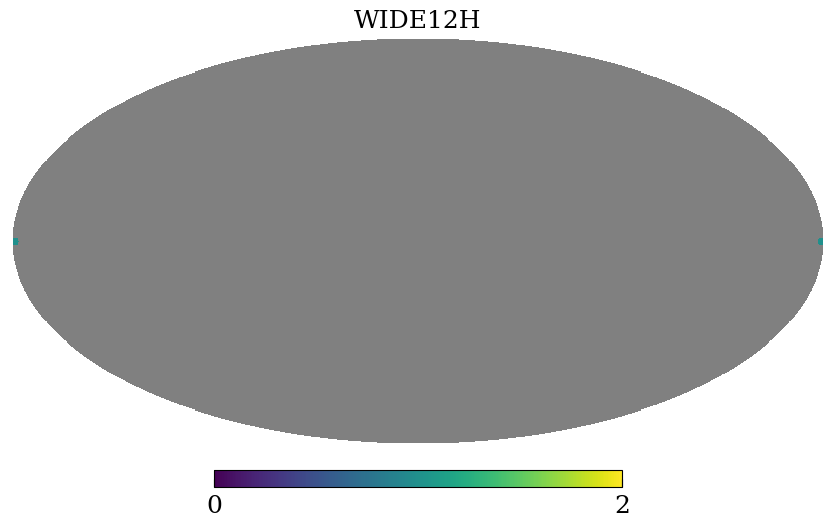

setting the output map dtype to [dtype('float64')]


>> Saving in Healpix format
>> Saving in Healsparse format
###########################
Processing XMM
###########################
Number of observed objects = 8308926
Number of stars = 1354842 (16.0%)
>> Mask type: galaxy


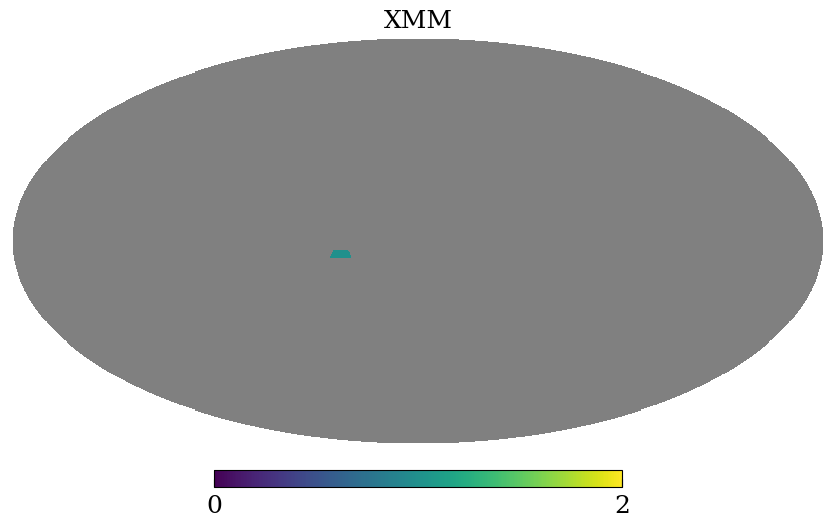

setting the output map dtype to [dtype('float64')]


>> Saving in Healpix format
>> Saving in Healsparse format
###########################
Processing VVDS
###########################
Number of observed objects = 11167565
Number of stars = 1792328 (16.0%)
>> Mask type: galaxy


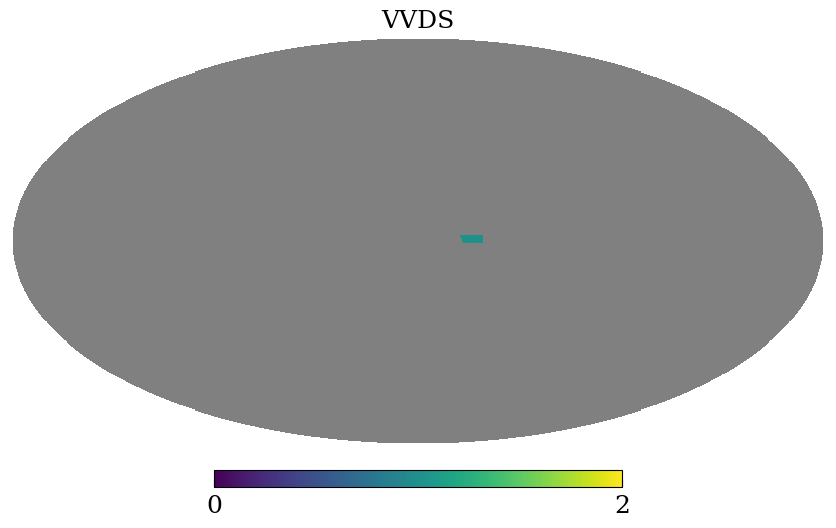

setting the output map dtype to [dtype('float64')]


>> Saving in Healpix format
>> Saving in Healsparse format


In [5]:
# Do we want to plot the field with stars and galaxies?
plot_field = True
plot_footprint = False

# Which kind of mask?
mask_type = 'galaxy' # 'galaxy' or 'star' or 'masked_fraction'
# 'galaxy' = 1 if there is a galaxy, 0 otherwise
# 'star' = 1 if there is a star, 0 otherwise
# 'masked_fraction' = 1 - 1 / number of galaxies per pixel

# Resolution of the map
nside = 4096

# HSC Fields
fname_list = ['gama09h_pdr1.fits', 'gama15h_pdr1.fits', 'wide12h_pdr1.fits', 'xmm_pdr1.fits', 'vvds_pdr1.fits']
label_list = ['gama09h', 'gama15h', 'wide12h', 'xmm', 'vvds']

for fname, label in zip(fname_list, label_list):
    print("###########################")
    print(f"Processing {label.upper()}")
    print("###########################")
    # Filename of the specific field
    fname = os.path.join(path, fname)
    # Read the data
    hdul = fits.open(fname)
    # Data is in the second extension
    data = hdul[1].data
    # Header
    header = hdul[1].header
    # Select stars 
    stars_cond = data['iclassification_extendedness'] == 0
    # Extract RA and Dec    
    ra = data['ra']
    print(f'Number of observed objects = {len(ra)}')
    dec = data['dec']
    # Keep information from stars
    ra_stars = ra[stars_cond]
    dec_stars = dec[stars_cond]
    print(f'Number of stars = {sum(stars_cond)} ({np.round(sum(stars_cond) / len(ra),2)*100}%)')
    # Create a SkyCoord object with RA and Dec
    pix_indices_stars = HSCMeasurementUtils.RaDecToIndex(ra_deg = ra_stars,
                                                        dec_deg = dec_stars,
                                                        nside = nside)
    pix_indices_galaxy = HSCMeasurementUtils.RaDecToIndex(ra_deg = ra,
                                                         dec_deg = dec,
                                                         nside = nside)
    # Reference to copy header
    fname_ref = '/global/cfs/projectdirs/lsst/groups/LSS/HSC_data/masked_fraction_nside4096_gama09hcorr_nohectomap.hs'
    mask = healsparse.HealSparseMap.read(fname_ref)
    mask = np.ones(12 * nside ** 2) * hp.UNSEEN 
    # Compute the number of pixels corresponding to the resolution
    npix = 12 * nside ** 2
    if mask_type == 'galaxy':
        print('>> Mask type: galaxy')
        # Simple version
        mask[pix_indices_galaxy] = 1
    elif mask_type == 'star':
        print('>> Mask type: star')
        # Simple version
        mask[pix_indices_galaxy] = 1
        mask[pix_indices_stars] = 0
    elif mask_type == 'masked_fraction':
        print('>> Mask type: masked fraction')
        # Compute the number of galaxies per pixel
        map_galaxy = np.bincount(pix_indices_galaxy, minlength=npix)
        # Compute the inverse of the number of galaxies per pixel
        mask = 1 - 1 / map_galaxy
    # Reorder pixels to nest ordering
    mask = hp.reorder(mask, r2n=True)

    if plot_field == True:
        hp.mollview(mask, title=label.upper(), nest=True)
        plt.show()
        plt.close()
    if plot_footprint == True:
        # Plot field with stars and galaxies
        plt.plot(ra, dec, 'k.', markersize=0.01,label='Galaxies')
        plt.plot(ra_stars, dec_stars, 'r.', markersize=0.01,label='Stars')
        # Title is the label in capital letters
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()
    # Save
    print('>> Saving in Healpix format')
    path_aux = os.path.join(path_save,mask_type)
    # Check if path_aux exists and create it if not
    if not os.path.exists(path_aux):
        os.makedirs(path_aux)
    hp.write_map(os.path.join(path_aux, f'mask_{mask_type}_nside{nside}.fits'),
                 mask,
                 nest=True,
                 overwrite=True)
    # To create a new map, the resolutions and datatype must be specified
    nside_coverage = 32
    nside_sparse = 4096
    # Initialize empty Healsparse map
    map3 = healsparse.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
    # Update values 
    map3.update_values_pix(np.arange(12*nside_sparse**2), mask, nest=True)
    # In healsparse format
    print('>> Saving in Healsparse format')
    map3.write(os.path.join(path_aux,f'mask_{mask_type}_nside{nside}_{label}.hs'), clobber=True)

## 'Detailed' mask

Guidelines by Javi:

ok, la idea es que quieres hacer un mapa que te diga dónde observas y dónde no. De hecho más concretamente quieres corregir cualquier cambio de densidad observada debido a que no observas todo el cielo o que no se observa todo de la misma forma. Pero no puede estar correlacionado con la estructura a gran escala y no tenemos la información de las exposiciones que fueron a los coadds de HSC (no son públicos estos). Entonces, en principio para los análisis se tiende a crear los mapas estos de magnitud límite. La idea es que sólo vas a poder observar objetos de cierta magnitud si pasas cierta cantidad de tiempo ahí. Lo malo es que si usas galaxias para construir estos mapas, la densidad de objetos va a estar correlacionada con la estructura a gran escala y entonces puedes sesgar un poco tus medidas (es un efecto muy pequeño). Si usas estrellas, las estrellas, a priori no están correlacionadas con la posición de galaxias (puesto que las estrellas están en la Vía Láctea así que no están influenciadas por la gravedad que no es de la Vía Láctea), entonces tu máscara es más limpia. El problema es que a alta latitud galáctica (que es donde se suelen hacer las medidas) la densidad de estrellas es baja, y por tanto la SNR de tus mapas de magnitud límite usando estrellas es un poco regular.

el proceso suele ser el siguiente:
Coges todas las estrellas de la muestra y las pones en un mapa.
En cada pixel calculas a qué magnitud le corresponde una SNR de ~10.
Este es tu mapa de magnitud límite.
Luego decides un corte (creo que en nuestro caso era 24.5). Los píxeles por debajo del corte se quedan fuera de la máscara y los píxeles por encima están dentro

la forma buena, buena de hacer esto es coger las exposiciones individuales y propagar las máscaras y las condiciones de observación de cada una y calcular la PSF y background del coadd y de ahí sacar la magnitud límite. Pero no tenemos acceso a esos datos.

luego el proceso se completa añadiendo la "bright star mask" donde eliminas zonas que están cerca de estrellas brillantes, porque éstas afectan los alrededores y hacer más difícil detectar objetos cercanos (básicamente cambian la profundidad ahí)

La SNR es calculada respecto a la magnitud en la cual definimos el corte, no? Creo que debería ser la magnitud i?

Javier Sanchez: sí, es i, exacto y la snr sería iflux/ifluxerror

This is hacky and should not work

In [3]:
""" show_plots = True

# Resolution of the map
nside = 4096

# HSC Fields
fname_list = ['gama09h_pdr1.fits'] #, 'gama15h_pdr1.fits', 'wide12h_pdr1.fits', 'xmm_pdr1.fits', 'vvds_pdr1.fits']
label_list = ['gama09h'] #, 'gama15h', 'wide12h', 'xmm', 'vvds']

for fname, label in zip(fname_list, label_list):
    print("###########################")
    print(f"Processing {label.upper()}")
    print("###########################")
    # Filename of the specific field
    fname = os.path.join(path, fname)
    # Read the data
    hdul = fits.open(fname)
    # Data is in the second extension
    data = hdul[1].data
    # Header
    header = hdul[1].header
    # header 
    # Select stars 
    stars_cond = data['iclassification_extendedness'] == 0
    # Extract RA and Dec of all objects   
    ra = data['ra']
    print(f'Number of observed objects = {len(ra)}')
    dec = data['dec']
    # Keep information from stars
    ra_stars = ra[stars_cond]
    dec_stars = dec[stars_cond]
    print(f'Number of stars = {sum(stars_cond)} ({np.round(sum(stars_cond) / len(ra),2)*100}%)')

    if show_plots:
        # Plotting all stars
        plt.plot(ra_stars, dec_stars, 'r.', markersize=0.01,label='Stars')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()

    # Extract magnitudes
    imag_psf = data['imag_psf']
    # imag_ap10 = data['imag_aperture10']
    # imag_cmod = data['icmodel_mag']

    # Set infinite values to zero
    imag_psf[np.isinf(imag_psf)] = np.nan
    # imag_ap10[np.isinf(imag_ap10)] = np.nan
    # imag_cmod[np.isinf(imag_cmod)] = np.nan

    if show_plots:
        # Plotting magnitude i distributions
        plt.hist(imag_psf, bins=100, histtype='step', label='PSF')
        plt.hist(imag_ap10, bins=100, histtype='step', label='Aperture 10')
        plt.hist(imag_cmod, bins=100, histtype='step', label='CModel')

        plt.xlabel('Magnitude i')
        plt.ylabel('Counts')
        plt.legend(frameon=False)
        plt.show()
        plt.close()

        # Distribution of i magnitude for stars
        # Plot ra and dec of the stars using the imag_psf as colormap
        plt.scatter(ra_stars, dec_stars, c=imag_psf[stars_cond], s=0.01, label='Stars')
        plt.colorbar(label='imag_psf')
        # plt.plot(ra_stars, dec_stars, 'r.', markersize=0.01,label='Stars')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()
    
    # Extract flux in i-band
    iflux_psf = data['iflux_psf'] # <-
    # iflux_ap10 = data['iflux_aperture10']
    # iflux_cmod = data['icmodel_flux']
    # Extract flux error in i-band
    iflux_psf_err = data['iflux_psf_err'] # <-
    # iflux_ap10_err = data['iflux_aperture10_err']
    # iflux_cmod_err = data['icmodel_flux_err']

    if show_plots:
        # Plot i flux histogram step with different colors
        # and the error in translucid
        plt.hist(iflux_psf / iflux_psf_err   , bins=20, color='b',histtype='step',label='PSF')
        plt.hist(iflux_ap10 / iflux_ap10_err , bins=20, color='r',histtype='step',label='Aperture 10')
        plt.hist(iflux_cmod / iflux_cmod_err, bins=20, color='g',histtype='step',label='Cmodel')

        plt.legend(frameon=False)
        plt.show()
        plt.close()
    
    # Compute the SNR of all objects
    iflux_psf_snr = iflux_psf / iflux_psf_err
    # Compute the SNR of stars
    iflux_psf_snr_stars = iflux_psf_snr[stars_cond]

    if show_plots:
        # Plot the SNR in i-band for stars
        plt.scatter(ra_stars, dec_stars, c=iflux_psf_snr_stars, s=0.01, label='Stars')
        plt.colorbar(label='iflux_psf_snr')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()

    # SNR i-band > 10 criteria
    snr_cond = iflux_psf_snr_stars >= 10

    # print percentage of stars that meet the SNR criteria
    print(f'Number of stars with SNR > 10 = {sum(snr_cond)} ({np.round(sum(snr_cond) / len(ra_stars),2)*100}%)')

    if show_plots:
        # Plot those stars that meet the SNR criteria with their SNR cmap
        plt.scatter(ra_stars[snr_cond], dec_stars[snr_cond], c=iflux_psf_snr_stars[snr_cond], s=0.01, label='Stars')
        plt.colorbar(label='iflux_psf_snr')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()

    # For this ra and dec of the stars that pass the first SNR in i-band > 10 criteria
    # let's save them and estimate their magnitude in the i-band
    cond_star_snr10 = stars_cond & (iflux_psf_snr >= 10)
    ra_stars_snr10 = ra[cond_star_snr10]
    dec_stars_snr10 = dec[cond_star_snr10]
    imag_psf_stars_snr10 = imag_psf[cond_star_snr10]

    # Print the length of the arrays defined in the previous cell
    print(len(ra_stars_snr10))
    print(len(dec_stars_snr10))
    print(len(imag_psf_stars_snr10))

    if show_plots:
        # For the subsample of stars with SNR > 10, plot their magnitude in i-band
        plt.scatter(ra_stars_snr10, dec_stars_snr10, c=imag_psf_stars_snr10, s=0.01, label='Stars')
        plt.colorbar(label='$mag^{psf}_i$')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()
    
    # Define the criteria for the subsample of stars with SNR > 10 and i-band magnitude > 24.5
    cond_star_snr10_imag245 = stars_cond & (iflux_psf_snr >= 10) & (imag_psf > 24.5)
    ra_stars_snr10_imag245 = ra[cond_star_snr10_imag245]
    dec_stars_snr10_imag245 = dec[cond_star_snr10_imag245]
    imag_psf_stars_snr10_imag245 = imag_psf[cond_star_snr10_imag245]

    # Print how many stars with SNR > 10 and i-band magnitude < 24.5
    # are in the sample and the percentage
    print(f'Number of stars with SNR > 10 and $mag_i$ > 24.5 = {sum(cond_star_snr10_imag245)} ({np.round(sum(cond_star_snr10_imag245) / len(ra_stars),2)*100}%)')

    if show_plots:
        # Plot the distribution of magnitude in i-band for stars with SNR > 10 and i-band magnitude < 24.5
        plt.scatter(ra_stars_snr10_imag245, dec_stars_snr10_imag245, c=imag_psf_stars_snr10_imag245, s=0.01, label='Stars')
        plt.colorbar(label='$mag^{psf}_i$')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()

        # Plot the distribution of magnitude in i-band for stars with SNR > 10 and i-band magnitude < 24.5
        plt.scatter(ra_stars_snr10_imag245, dec_stars_snr10_imag245, s=0.01, label='Stars')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()
        
    # Number of pixels corresponding to the resolution
    npix = 12 * nside ** 2
    # Initialize empty map
    map = np.ones(npix) * hp.UNSEEN

    # Transform ra and dec of all objects to pixels
    pix_indices_all = HSCMeasurementUtils.RaDecToIndex(ra_deg = ra,
                                                        dec_deg = dec,
                                                        nside = nside)

    # Transform the ra and dec of the stars with SNR > 10 and i-band magnitude < 24.5 to pixels
    pix_indices_stars_snr10_imag245 = HSCMeasurementUtils.RaDecToIndex(ra_deg = ra_stars_snr10_imag245,
                                                                        dec_deg = dec_stars_snr10_imag245,
                                                                        nside = nside)
    
    # Set the pixels corresponding to the stars with SNR > 10 and i-band magnitude < 24.5 to 1
    map[pix_indices_all] = 0
    map[pix_indices_stars_snr10_imag245] = 1

    # Reorder pixels to nest ordering
    map = hp.reorder(map, r2n=True)

    if show_plots:
        # Plot the map
        hp.mollview(map, title=label.upper(), nest=True)
        plt.show()
        plt.close()

        # Plot all objects ra and dec 
        plt.plot(ra, dec, 'k.', markersize=0.01,label='Galaxies')
        # Plot stars that meet the SNR criteria and i-band magnitude < 24.5
        plt.plot(ra_stars_snr10_imag245, dec_stars_snr10_imag245, 'r.', markersize=0.01,label='Stars')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        # The color of the legend label is the same as the color of the points
        plt.legend(frameon=False, labelcolor='linecolor')
        plt.show()
        plt.close()

    mask_type = 'star_snr10_imag245'
    # Save
    print('>> Saving in Healpix format')
    path_aux = os.path.join(path_save,mask_type)
    # Check if path_aux exists and create it if not
    if not os.path.exists(path_aux):
        os.makedirs(path_aux)
    hp.write_map(os.path.join(path_aux, f'mask_{mask_type}_nside{nside}.fits'),
                    map,
                    nest=True,
                    overwrite=True)
    # To create a new map, the resolutions and datatype must be specified
    nside_coverage = 32
    nside_sparse = nside
    # Initialize empty Healsparse map
    map3 = healsparse.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
    # Update values 
    map3.update_values_pix(np.arange(12*nside_sparse**2), map, nest=True)
    # In healsparse format
    print('>> Saving in Healsparse format')
    map3.write(os.path.join(path_aux,f'mask_{mask_type}_nside{nside}_{label}.hs'), clobber=True) """

' show_plots = True\n\n# Resolution of the map\nnside = 4096\n\n# HSC Fields\nfname_list = [\'gama09h_pdr1.fits\'] #, \'gama15h_pdr1.fits\', \'wide12h_pdr1.fits\', \'xmm_pdr1.fits\', \'vvds_pdr1.fits\']\nlabel_list = [\'gama09h\'] #, \'gama15h\', \'wide12h\', \'xmm\', \'vvds\']\n\nfor fname, label in zip(fname_list, label_list):\n    print("###########################")\n    print(f"Processing {label.upper()}")\n    print("###########################")\n    # Filename of the specific field\n    fname = os.path.join(path, fname)\n    # Read the data\n    hdul = fits.open(fname)\n    # Data is in the second extension\n    data = hdul[1].data\n    # Header\n    header = hdul[1].header\n    # header \n    # Select stars \n    stars_cond = data[\'iclassification_extendedness\'] == 0\n    # Extract RA and Dec of all objects   \n    ra = data[\'ra\']\n    print(f\'Number of observed objects = {len(ra)}\')\n    dec = data[\'dec\']\n    # Keep information from stars\n    ra_stars = ra[stars_con

This is the correct way of generating the mask. Follow this approach!!!!

>> nside = 2048
###########################
Processing GAMA09H
###########################


Number of observed objects = 6496607
Number of stars = 1128219 (17.0%)


/opt/desc/py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


>> Reading /global/cfs/projectdirs/lsst/groups/LSS/HSC_data/masked_fraction_nside4096_gama09h.fits
nans in the mask?
False


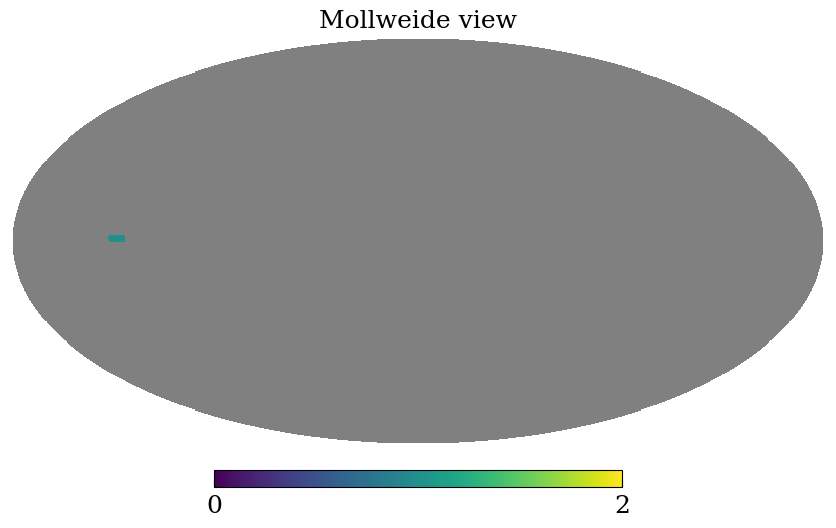

>> Saving in Healsparse format
>> Saving in Healsparse format
###########################
Processing GAMA15H
###########################
Number of observed objects = 7681225
Number of stars = 1384985 (18.0%)


/opt/desc/py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


>> Reading /global/cfs/projectdirs/lsst/groups/LSS/HSC_data/masked_fraction_nside4096_gama15h.fits
nans in the mask?
False


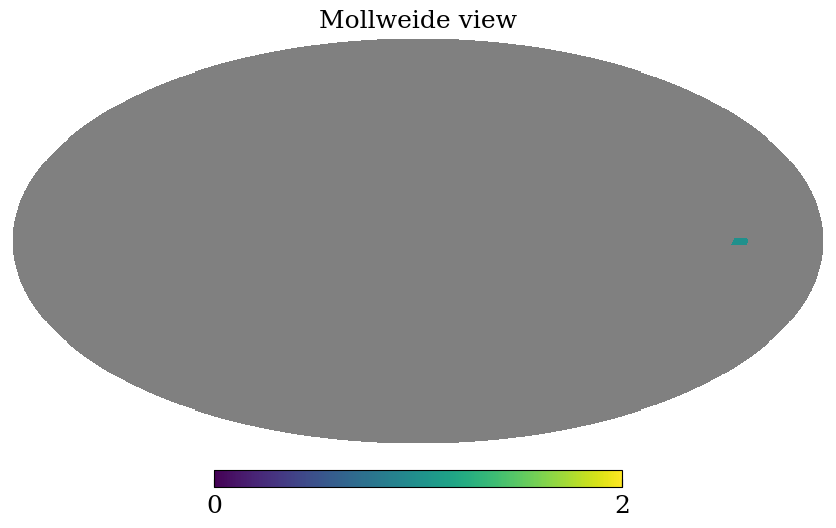

>> Saving in Healsparse format
>> Saving in Healsparse format
###########################
Processing WIDE12H
###########################
Number of observed objects = 5625072
Number of stars = 898111 (16.0%)


/opt/desc/py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


>> Reading /global/cfs/projectdirs/lsst/groups/LSS/HSC_data/masked_fraction_nside4096_wide12h.fits
nans in the mask?
False


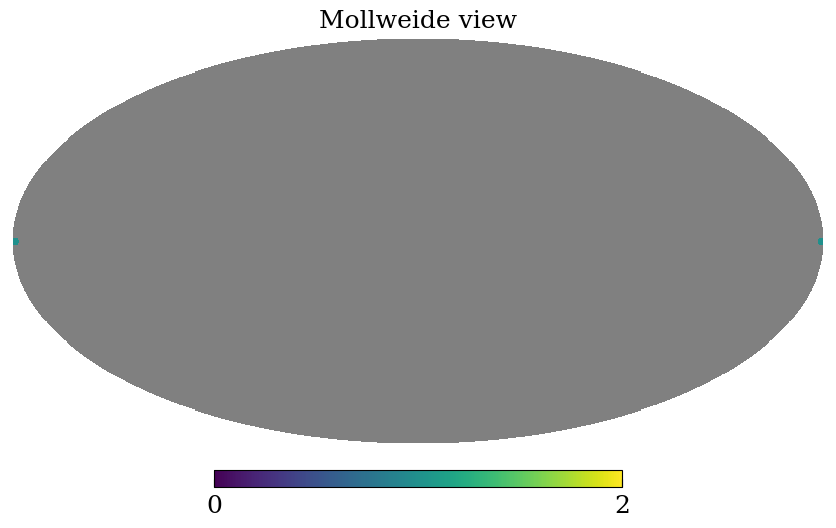

>> Saving in Healsparse format
>> Saving in Healsparse format
###########################
Processing XMM
###########################
Number of observed objects = 8308926
Number of stars = 1354842 (16.0%)


/opt/desc/py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


>> Reading /global/cfs/projectdirs/lsst/groups/LSS/HSC_data/masked_fraction_nside4096_xmm.fits
nans in the mask?
False


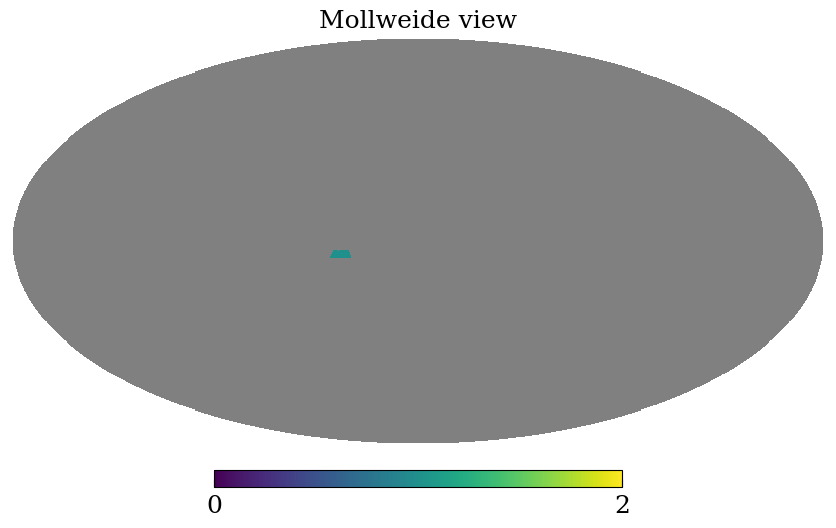

>> Saving in Healsparse format
>> Saving in Healsparse format
###########################
Processing VVDS
###########################
Number of observed objects = 11167565
Number of stars = 1792328 (16.0%)


/opt/desc/py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


>> Reading /global/cfs/projectdirs/lsst/groups/LSS/HSC_data/masked_fraction_nside4096_vvds.fits
nans in the mask?
False


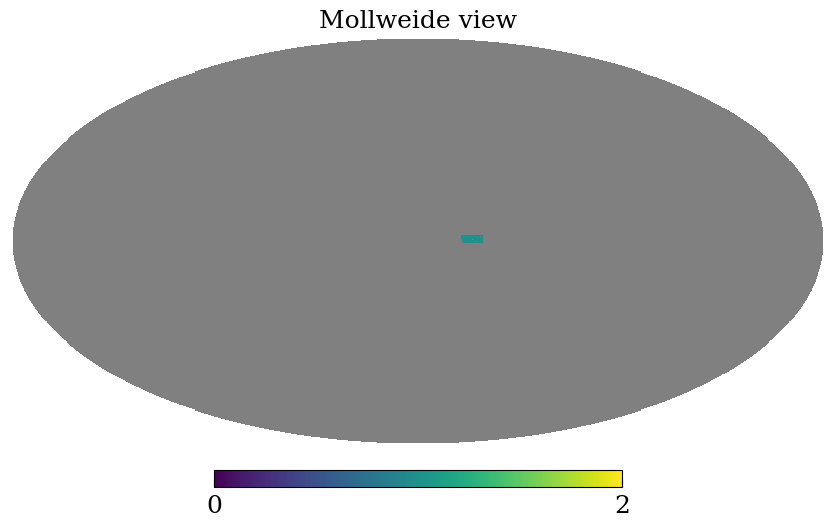

>> Saving in Healsparse format
>> Saving in Healsparse format


In [4]:
show_plots = False

# Resolution of the map
nside = 2048
print(f'>> nside = {nside}')

# HSC Fields
fname_list = ['gama09h_pdr1.fits', 'gama15h_pdr1.fits', 'wide12h_pdr1.fits', 'xmm_pdr1.fits', 'vvds_pdr1.fits']
label_list = ['gama09h', 'gama15h', 'wide12h', 'xmm', 'vvds']

for fname, label in zip(fname_list, label_list):
    print("###########################")
    print(f"Processing {label.upper()}")
    print("###########################")
    # Filename of the specific field
    fname = os.path.join(path, fname)
    # Read the data
    hdul = fits.open(fname)
    # Data is in the second extension
    data = hdul[1].data
    # Header
    header = hdul[1].header
    # header 
    # Select stars 
    stars_cond = data['iclassification_extendedness'] == 0
    # Extract RA and Dec of all objects   
    ra = data['ra']
    print(f'Number of observed objects = {len(ra)}')
    dec = data['dec']
    # Keep information from stars
    ra_stars = ra[stars_cond]
    dec_stars = dec[stars_cond]
    print(f'Number of stars = {sum(stars_cond)} ({np.round(sum(stars_cond) / len(ra),2)*100}%)')

    if show_plots:
        # Plotting all stars
        plt.plot(ra_stars, dec_stars, 'r.', markersize=0.01,label='Stars')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()

    # Extract magnitudes 
    imag_psf = data['imag_psf']
    # Set infinite values to zero
    imag_psf[np.isinf(imag_psf)] = np.nan

    if show_plots:
        # Plotting magnitude i distributions
        plt.hist(imag_psf, bins=100, histtype='step', label='PSF')
        plt.hist(imag_ap10, bins=100, histtype='step', label='Aperture 10')
        plt.hist(imag_cmod, bins=100, histtype='step', label='CModel')

        plt.xlabel('Magnitude i')
        plt.ylabel('Counts')
        plt.legend(frameon=False)
        plt.show()
        plt.close()

        # Distribution of i magnitude for stars
        # Plot ra and dec of the stars using the imag_psf as colormap
        plt.scatter(ra_stars, dec_stars, c=imag_psf[stars_cond], s=0.01, label='Stars')
        plt.colorbar(label='imag_psf')
        # plt.plot(ra_stars, dec_stars, 'r.', markersize=0.01,label='Stars')
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()
    
    # Extract flux in i-band and error
    iflux_psf = data['iflux_psf'] # <-
    # Extract flux error in i-band
    iflux_psf_err = data['iflux_psf_err'] # <-
    # Compute the SNR of all objects
    snr = iflux_psf / iflux_psf_err
    # Compute the SNR of stars
    snr_stars = snr[stars_cond]
    # Compute the i-mag of stars
    mag_psf_stars = imag_psf[stars_cond]
    # Compute the pixelization of stars
    pix_indices_stars = HSCMeasurementUtils.RaDecToIndex(ra_deg = ra_stars,
                                                        dec_deg = dec_stars,
                                                        nside = nside)
    # Compute the map of median SNR and set this to be within [9.7, 10.3]
    median_mag, _, snr_edges, _ = binned_statistic_2d(pix_indices_stars,
                                                    snr_stars,
                                                    mag_psf_stars,
                                                    bins=(12*nside**2, 1),
                                                    range=([0, 12*nside**2+1], [8, 12]),
                                                    statistic=np.nanmedian)  # play with the width of the SNR bin
    # Convert median mag to a flat array
    median_mag = median_mag.flatten()
    """ # Check if there are nan values in snr_stars
    print(np.isnan(snr_stars).any())
    # Chcek if there are nan values in mag_psf_stars
    print(np.isnan(mag_psf_stars).any())
    # Check if all the elements in median_mag are nan
    print(np.isnan(median_mag).all()) """
    # Reorder pixels to nest ordering
    median_mag = hp.reorder(median_mag, r2n=True)
    # Using np.where put pixels to 0 if the magnitude is lower than 24.5 and 1 if the magnitude is higher than 24.5
    median_mag[np.where(median_mag < 24.5)] = 0
    median_mag[np.where(median_mag >= 24.5)] = 1
    # Read old mask containing "bright star mask"
    # label_list = ['gama09h'] #, 'gama15h', 'wide12h', 'xmm', 'vvds']
    path_old_mask = '/global/cfs/projectdirs/lsst/groups/LSS/HSC_data/'
    if label == 'gama09h':
        fname = os.path.join(path_old_mask, 'masked_fraction_nside4096_gama09h.fits')
    elif label == 'gama15h':
        fname = os.path.join(path_old_mask, 'masked_fraction_nside4096_gama15h.fits')
    elif label == 'wide12h':
        fname = os.path.join(path_old_mask, 'masked_fraction_nside4096_wide12h.fits')
    elif label == 'xmm':
        fname = os.path.join(path_old_mask, 'masked_fraction_nside4096_xmm.fits')
    elif label == 'vvds':
        fname = os.path.join(path_old_mask, 'masked_fraction_nside4096_vvds.fits')
    print(f'>> Reading {fname}')
    # Load fits file
    old_mask = healsparse.HealSparseMap.read(fname)
    # Convert healsparse map to healpix and downgrade to 2048
    old_mask = old_mask.generate_healpix_map(nside=2048, reduction='mean')
    # Multiply those median_mag and old_mask pixels which are not hp.UNSEEN in any map
    median_mag[old_mask != hp.UNSEEN] *= old_mask[old_mask != hp.UNSEEN]
    # Pixels which are 1 set to 1
    median_mag[median_mag > 0] = 1
    # Set nans to 0
    median_mag[np.isnan(median_mag)] = hp.UNSEEN
    # Check if there are nan values in median_mag
    print('nans in the mask?')
    print(np.isnan(median_mag).any())
    # Pixels which are not 1 and different to hp.UNSEEN set to 0
    # median_mag[(median_mag > 0) * (median_mag <= 1)] = 1
    # median_mag[median_mag == 0] = 0
    # Plot the mask to be saved
    hp.mollview(median_mag, nest=True)
    plt.show()
    plt.close()
    mask_type = 'star_snr10_imag245'
    # Save
    path_aux = os.path.join(path_save,mask_type)
    # Check if path_aux exists and create it if not
    if not os.path.exists(path_aux):
        os.makedirs(path_aux)
    # To create a new map, the resolutions and datatype must be specified
    nside_coverage = 32
    nside_sparse = nside
    # Initialize empty Healsparse map
    map3 = healsparse.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
    # Update values 
    map3.update_values_pix(np.arange(12*nside_sparse**2), median_mag, nest=True)
    # In healsparse format
    print('>> Saving in Healsparse format')
    map3.write(os.path.join(path_aux,f'mask_{mask_type}_nside{nside}_{label}.hs'), clobber=True)